# <font  color = "#0093AF"> Correlation-time dependence of a pulse-sequence: RECRR

A challenge in acquiring $R_{1\rho}$ relaxation rate constants is that coherent oscillation is present at the beginning of the $R_{1\rho}$ period, which distorts the signal decay. While we could wait until oscillation is subsided, the beginning of the relaxation period is particularly important, because $R_{1\rho}$ relaxation is multiexponential. The initial slope of decay gives the averaged rate constant, which is what we would like to acquire. However, after time, the faster relaxing components have decayed more than the slower components, so that the slope no longer represents the average rate constant.

Keeler et al. propose a solution to suppress oscillation at the beginning of the $R_{1\rho}$ period, where the spin-lock (CW$_{\pm x}$)  are switched in phase, and $\pi$-pulses are inserted to also invert the magnetization:$^1$ 

CW$_x$ - $\pi_y$ - CW$_{-x}$ – CW$_{-x}$ - $\pi_{-y}$ CW$_x$

The spin-locks each have an integer number of rotor periods.

We will investigate this sequence here and compare its performance to the standard $R_{1\rho}$ experiment

[1] E.G. Keeler, K.J. Fritzsching, A.E. McDermott. *[J. Magn. Reson](https://doi.org/10.1016/j.jmr.2018.09.004)*, **2018**, 296, 130-137.

In [15]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [16]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

In [85]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=16000,pwdavg=sl.PowderAvg(),n_gamma=50)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,15*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,15*np.pi/180,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=200e-6)

In [86]:
Ux=L.Sequence().add_channel('15N',v1=22000).U()
Umx=L.Sequence().add_channel('15N',v1=22000,phase=np.pi).U()
Upiy=L.Udelta('15N',phase=np.pi/2)
Upimy=L.Udelta('15N',phase=3*np.pi/2)

R1p=sl.Rho('15Nx','15Nx')

R1p,Ux,Umx,Upiy,Upimy=R1p.ReducedSetup(Ux,Umx,Upiy,Upimy)
RECRR=R1p.copy_reduced()

State-space reduction: 32->16


/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:635: UserWarning: Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho')


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

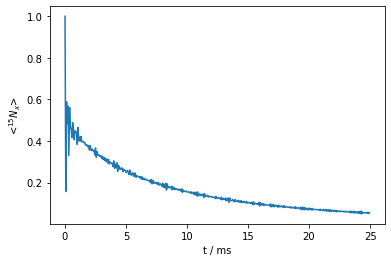

In [87]:
R1p.clear()
R1p.DetProp(Ux,n=400)
R1p.plot()

/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:635: UserWarning: Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho')


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

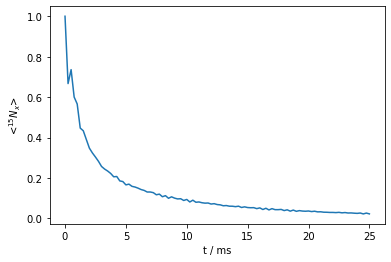

In [88]:
RECRR.clear()
Umx0=Umx
Ux0=Ux
RECRR()
for k in range(100):
    RECRR.reset()
    (Umx0*Upimy*Umx0*Ux0*Upiy*Ux0*RECRR)()
    Umx0=Umx*Umx0
    Ux0=Ux*Ux0
RECRR.plot()

/Users/albertsmith/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


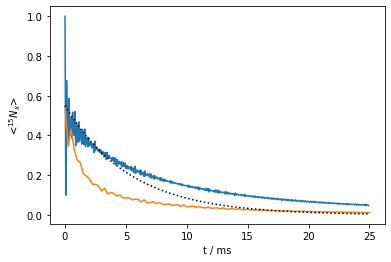

In [82]:
ax=R1p.plot()
sc=0.55
ax.plot(RECRR.t_axis*1e3,RECRR.I[0]*sc)
ax.plot(R1p.t_axis*1e3,
        sc*np.exp(-R1p.t_axis*R1p.reset().extract_decay_rates(Ux,pwdavg=True)),
       color='black',linestyle=':')